# Derivativos de Ações e Commodities
##  Precificação com o Método de Diferenças Finitas
<sub>Uirá Caiado. 29 de Junho, 2016<sub>

#### Resumo

_Neste projeto vou implementar o método de diferenças finitas explícito para precificar diferentes derivativos. Como o preço de opções geralmente é descrito por equações diferenciais de difusão ou parabólicas, o método de diferenças finitas se mostra adequado, uma vez que é utilizado justamente para encontrar soluções numéricas para equações diferencias. Depois e implementar o modelo, vou compará-lo com os resultados obtidos pela solução analítica de cada instrumento._

## 1. Introdução

Nesta seção dou uma breve descrição sobre o método de diferenças finitas e declaro o problema que será abordado.

### 1.1. O Método Utilizado

Como colocado por Wilmott, encontrar soluções fechadas para precificação de muitos derivativos pode ser difícil, ou mesmo inviável. Como o preço destes instrumentos frequentemente são descritos por equações diferencias parciais, frequentemente utilizam-se métodos numéricos para encontrar uma solução, como [árvores binomiais](https://en.wikipedia.org/wiki/Binomial_options_pricing_model), simulação de [monte carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) e diferenças finitas.

O método de diferenças finitas encontra o valor de um derivativo calculando-o em todo domínio (factivel) de preços do instrumento base, incluíndo a passagem de tempo até seu vencimento.  Assim, são similares às árvores binomiais. Porém, ao invéz e discretizar os preços do ativo e a passagem do tempo em uma estrutura de árvore, discretiza em um grid.

Diferenças finitas também são muitos boas para lidar com problemas com poucas dimensões e equações diferenciais não lineares (o preço e tempo já são duas, e o Wilmott sugere até quatro). Para muitas dimensões, a implementação começa a ficar complicada e pouco eficiente, coisa que o Monte Carlo lida melhor. Porém, se há exercício antecipado e não linearidade, o método de diferenças finitas acaba se mostrando como solução mais viável.

### 1.2. O Problema

Considerando um ativo-objeto cuja dinâmica do preço satisfaz a seguinte EDE:

$$\frac{\mathrm{d} S_t}{S_t}=\mu\cdot \mathrm{d}t + \sigma\cdot \mathrm{d}W_{t}$$

Deseja-se calcular o preço justo de um derivativo um derivativo com característica europeia cujo payoff é descrito por uma função qualquer $V_T=V(T, S_T)$, onde $T$ é o vencimento do derivativo. $S_T$ é o preço do ativo-objeto em $T$ e é possível negociar qualquer quantidade dele em qualquer instante. Não há custo de transação (corretagem, emolumento, bid-ask spread, etc) e posições vendidas a descoberto no subjacente são permitidas, não havendo custos associados.

Pede-se que se implemente o algoritmo de diferenças finitas explícito e se calcule o (a) preço justo, (b) o Delta e (c) o Gamma de cada instrumento abaixo. Os valores encontrados devem ser comparados com o resultado de suas expressões analítica. A simulação deve ser feita para os payoffs abaixo. $K$ é o Strike da opção.
- $V(T, S_T)=ln(S_T)$
- $V(T, S_T)=(ln(S_T))^2$
- $V(T, S_T)=(S_T-K)^2$
- $V(T, S_T)=\mathbf{1}_{S_T > K}$
- $V(T, S_T)=max(S_T-K, 0)$

##  2. Diferenças Finitas

Abaixo, apresentarei os elementos necessários para implementar o método diferenças finitas, sendo eles: a [diferenciação](https://pt.wikipedia.org/wiki/Diferenciação_numérica) das derivadas parciais necessárias usando o Grid; a discretização da condição final para cada derivativo; e suas respectivas condições de contorno (nos limites do grid).

### 2.1. Diferenciação no Grid

De acordo com Wilmott, o grid utilizado pelo método de diferenças finitas tem passos de tempo e de preço (ou log do preço) geralmente homogênios. Porém, **não há** restrição para a forma do Grid, desde que os ajustes necessários sejam feitos. Como exposto por 

Considerando que podemos discretizar $t$ como $t=T-k\delta t$ e do $S$ como $S = i\delta S$, onde $i$ e $k$ são seus respectivos passos no grid, podemos escrever o valor da opção em cada ponto do grig como sendo:

$$V^{k}_{i} = ( i \delta S, T-k \delta t )$$

Seguindo notas de aula, aplicando Taylor ao preço $V(T, S_T)$ de um derivativo genérico, posso escrever a seguinte equação diferencial parabólica:

$$\frac{\partial V}{\partial t} + a(S, t) \cdot \frac{\partial V^2}{\partial S^2} + b(S, t) \cdot \frac{\partial V}{\partial S} + c(S, t)\cdot V = 0 $$

Sendo que $\frac{\partial V}{\partial t}$ também é chamado de theta ($\theta$), $\frac{\partial V}{\partial S}$ de delta ($\Delta$) e $\frac{\partial V^2}{\partial S^2}$ de gamma ($\Gamma$). Como demostrado por Wilmott, como a definição da primeira derivada $V$ em relação a $t$ é dado por

$$\frac{\partial V}{\partial t} = \underset{h \, \rightarrow \, 0}{\lim}\, \frac{V(S, t + h) - V(S, t)}{h}$$

Então podemos aproximar $\theta$ como sendo $\frac{\partial V}{\partial t} (S, t) \approx \frac{V_{i}^{k} - V_{i}^{k+1} }{\delta t}$. Note que $i$, que é relacionado ao passo do ativo, ficou fixo. *Também estou ignorando os erros de aproximação, como ignorarei em todas as outras diferenciações*.

O mesmo raciocínio pode ser utilizado para aproximar o $\Delta$. Porém, Wilmott ainda sugere que se utilize a [diferença centrada](http://math.stackexchange.com/questions/888259/can-someone-explain-in-general-what-a-central-difference-formula-is-and-what-it), que é dada por $\frac{\partial V}{\partial S} (S, t) \approx \frac{V_{i+1}^{k} - V_{i-1}^{k} }{2 \delta S}$. A discretização anterior também poderia ser utilizada, mas esta oferece um erro de aproximação menor. O único problema desta abordagem é que preciso saber os valores $S + \delta S$ e $S - \delta S$ e nas fronteiras do Grid não terei esta informação. Por tanto, nestes casos utilizarei a discretrização utilizando apenas um dos lados.

Por fim, para achar o $\gamma$, Wilmott subtrai o delta forward do delta backward e divide o resultado por $\delta S$, chegando na aproximação  $\frac{\partial V^2}{\partial S^2} (S, t) \approx \frac{V_{i+1}^{k} - 2 V_{i}^{k} + V_{i-1}^{k} }{\delta S^2}$. Como demonstrado em notas de aula, todos estes resultados podem ser checados aplicando a expansão de Taylor.

### 2.2. Condição Terminal e Payoffs

O valor da opção no vencimento é simplemente seu payoff. Assim, não é necessário resolver nada para $T$, apenas para $S$. Usando a notação de diferenças finitas, os payoffs desejados ficam sendo da forma:

- $V_{i}^{0}=ln(i\delta S)$
- $V_{i}^{0}=(ln(i\delta S))^2$
- $V_{i}^{0}=(i\delta S-K)^2$
- $V_{i}^{0}=\mathbf{1}_{i\delta S > K}$
- $V_{i}^{0}=max(i\delta S-K, 0)$

Como o Wilmott explica, o método de diferenças finitas começa de trás para frente, será destes valores que a iteração começará, como se estivéssemos calculando o preço de um derivativo por árvores binomiais, também de trás para frente.

### 2.3. Condições de Contorno

Quando estivermos percorrendo o Grid, necessitaremos definir o preço do derivativo em seus extremos, quando $S=0$ e $S=I \delta S$, onde $I$ é o ponto mais alto do Grid. Esta condição depende do instrumento que está sendo precificado. Para **todos** dos contratos, utilizaremos a seguinte condição para quando $S=0$:

$$V^{k}_{0} = (1 - r \delta t)V^{k-1}_{0}$$

Para a condição de contorno superior, utilizaremos para a **maioria dos contratos**:

$$V^{k}_{I} = 2V^{k}_{I-1} - V^{k}_{I-2}$$

Esta condição é adequada pois, a medida que $S \rightarrow \infty$, o $\Gamma$ da maioria dos contratos tende a zero. Porém, isso não é verdade para o contrato cujo payoff é descrito por $V_{i}^{0}=(i\delta S-K)^2$. Diferenciando novamente o [delta](https://nbviewer.jupyter.org/github/ucaiado/Replicating_Strategy/blob/master/UiraCaiadoEx01.ipynb) deste contrato, chegamos que o gamma será dado por $2 \cdot e^{(r + \sigma^2)(T-t)}$. Neste caso,
partindo da equação discretizada do $\Gamma$ e resolvendo para $V^{k}_{I}$, tenho que:

\begin{equation}
\begin{aligned}
\Gamma &= \frac{V_{I+1}^{k} - 2 V_{I}^{k} + V_{I-1}^{k} }{\delta S^2}\\
2 \cdot e^{(r + \sigma^2)(\delta t)} &= \frac{V_{I+1}^{k} - 2 V_{I}^{k} + V_{I-1}^{k} }{\delta S^2}\\
V_{I}^{k} &= 2 \delta S^2 e^{(r + \sigma^2)(\delta t)} + 2V_{I-1}^{k} - V_{I-2}^{k}\\
V_{I}^{k} &\approx 2 \delta S^2 + 2V_{I-1}^{k} - V_{I-2}^{k}\\
\end{aligned}
\end{equation}



## 3. Implementando o Modelo

Nesta seção vou decsrever o método de diferenças finitas explícito e implementar os códigos necessários.

### 3.1. Método Explícito

Seguindo notas de aula, substituindo as diferenciações encontradas na equação parabólica mencionada anteriormente e reescrevendo os outros termos com a notação de diferenças finitas, temos que:

\begin{equation}
\begin{aligned}
\frac{\partial V}{\partial t} + a(S, t) \cdot \frac{\partial V^2}{\partial S^2} + b(S, t) \cdot \frac{\partial V}{\partial S} + c(S, t)\cdot V &= 0 \\
\frac{V_{i}^{k} - V_{i}^{k+1} }{\delta t} + a_{i}^{k} \cdot \frac{V_{i+1}^{k} - 2 V_{i}^{k} + V_{i-1}^{k} }{\delta S^2} + \\b_{i}^{k} \cdot \frac{V_{i+1}^{k} - V_{i-1}^{k} }{2 \delta S} + c_{i}^{k}\cdot V_{i}^{k} &= 0
\end{aligned}
\end{equation}

Rearranjando equação acima para isolar $V_{i}^{k+1}$ e renomeando alguns termos, ficamos com:

$$V_{i}^{k+1} = A_{i}^{k}V_{i-1}^{k} + \left( 1 + B_{i}^{k} \right)V_{i}^{k} + C_{i}^{k}V_{i+1}^{k}$$

Onde:

\begin{equation}
\begin{aligned}
A_{i}^{k} &= \nu_1 a_{i}^{k} - 0.5\nu_2 b_{i}^{k} \\
B_{i}^{k} &= -2\nu_1 a_{i}^{k} - \delta t c_{i}^{k} \\
C_{i}^{k} &= \nu_1 a_{i}^{k} + 0.5\nu_2 b_{i}^{k}
\end{aligned}
\end{equation}

Sendo que $\nu_1=\frac{\delta t}{\delta S ^2}$ e $\nu_2=\frac{\delta t}{\delta S}$. A equação acima está definida apenas entre $i=1, ..., I-1$. OS pontos restantes necessários para discretização vem das condições de contorno. Como nós conhecemos o valor terminal em $V_{i}^{0}$, podemos calcular o valor de $V_{i}^{1}$ e assim por diante. Como o valor do instrumento em $k+1$ só depende dos valores dele em $k$, chamamos este método de **método explícito**.

### 3.2. Outros Detalhes

#### a. Estabilidade

Para que a solução deste método seja estável, é necessário que satisfaça $\delta t \, \leqslant \frac{\delta S^2}{2\sigma^2 S^2}$ e $\delta S \leqslant \frac{2a}{|b|}$. Vou utilizar a primeira delas explicitamente na implementação, porém vou fazer a seguinte transformação:

$$\delta t \, \leqslant \frac{\delta S^2}{2\sigma^2 S^2} = \frac{1}{\sigma^2} \left(\frac{\delta S}{S}\right)^2 = \frac{1}{\sigma^2 I^2}$$

Onde $I = \delta  S \times S$.

#### b. Interpolação Bilinear

Devido a discretização do modelo, pode ser que seja necessário obter um valor que esteja entre os nós do Grid. Nestes casos, adotarei uma interpolação de duas dimensões (Preço e tempo) chamada [interpolação bilinear](https://en.wikipedia.org/wiki/Bilinear_interpolation). Ela consiste em realizar uma interpolação linear primeiro em uma direção e depois na outra. Considerando um quadrante específico do Grid, em que há quatro preços de opção, basicamente se divide o quadrante em quatro (onde os pontos de divisão são os valores desejados) e se utiliza a área de cada um deles como peso para os valores das opções. Assim, terminamos com a seguinte fórmula:

$$\frac{\sum_{i=1}^{4} A_i V_i}{\sum_{i=1}^{4} A_i}$$

Onde $A$ é a área dos retângulos e $V$ o preço da opção em cada canto do quadrante principal. Cada $A_i$ é oposto ao $V_i$ correspondente (o $A_2$ é oposto ao $V_2$, por exemplo).

### 3.3. Criando o Grid

Primeiro, vou definir as classes para a criação do Grid. Como quero acessar os valores posteriormente, vou manter todos em uma estrutura, ainda que este provavelmente não seja o método mais adequado pensando em velocidade.

In [415]:
import finite_difference; reload(finite_difference);
x = finite_difference.Grid(f_vol=0.5,
                           f_value=100.,
                           f_time=1.,
                           i_nas=10,
                           i_nts=10)
print x

       0     1     2     3     4     5     6     7     8     9
0    0,0   0,1   0,2   0,3   0,4   0,5   0,6   0,7   0,8   0,9
1    1,0   1,1   1,2   1,3   1,4   1,5   1,6   1,7   1,8   1,9
2    2,0   2,1   2,2   2,3   2,4   2,5   2,6   2,7   2,8   2,9
3    3,0   3,1   3,2   3,3   3,4   3,5   3,6   3,7   3,8   3,9
4    4,0   4,1   4,2   4,3   4,4   4,5   4,6   4,7   4,8   4,9
5    5,0   5,1   5,2   5,3   5,4   5,5   5,6   5,7   5,8   5,9
6    6,0   6,1   6,2   6,3   6,4   6,5   6,6   6,7   6,8   6,9
7    7,0   7,1   7,2   7,3   7,4   7,5   7,6   7,7   7,8   7,9
8    8,0   8,1   8,2   8,3   8,4   8,5   8,6   8,7   8,8   8,9
9    9,0   9,1   9,2   9,3   9,4   9,5   9,6   9,7   9,8   9,9
10  10,0  10,1  10,2  10,3  10,4  10,5  10,6  10,7  10,8  10,9


In [416]:
%timeit x = Grid(f_vol=0.2, f_value=100., f_time=1., i_nas=10)

1000 loops, best of 3: 344 µs per loop


Como comentei, não é uma estrtutura eficiente. Demorou quase 5 segundos para criar uma estrtutura de 10.000 nós. Porém acredito que isso me ajudará adiante.

### 3.3. Precificando os instrumentos

Seguindo implementação do livro, também há outra opção para se encontrar $V_{i}^{k+1}$. Substituindo a notação da fórmula de precificação e assumindo que possuimos os valores para $\Delta$, $\Gamma$ e $V_{i}^{k}$, podemos isolar o $\theta$, ficando com


\begin{equation}
\begin{aligned}
\theta + a_{i}^{k} \cdot \Gamma + b_{i}^{k} \cdot \Delta + c_{i}^{k}\cdot V_{i}^{k} &= 0\\
-a_{i}^{k} \cdot \Gamma - b_{i}^{k} \cdot \Delta - c_{i}^{k}\cdot V_{i}^{k} &= \theta
\end{aligned}
\end{equation}

Assim, para uma opção que não paga dividendos, que o ativo base segue um movimento brawniano geométrico, e esta sendo avaliado no mundo neutro a risco, temos que o parâmetro $c=-r$, $b=rS$ e $a=0.5 \cdot \sigma^2 S^2$. Assim, fico com o theta sendo da forma:

$$\theta = r V_{i}^{k} - rS_{i}^{k}\Delta - 0.5\sigma^2 S^2\Gamma$$

Então, o preço do derivativo em $k+1$ pode ser dado por:

$$V_{i}^{k+1} = V_{i}^{k} - \delta t \theta$$

Para comparar os resultados obtidos, também serão calculados os preços e as gregas de cada opção analiticamente, seguindo as equações de preficição demostradas em [trabalho](https://nbviewer.jupyter.org/github/ucaiado/Replicating_Strategy/blob/master/UiraCaiadoEx01.ipynb) anterior. Abaixo vou imprimir os resultados obtidos para uma Call Européia para comparação com exemplos do Wilmott.

In [418]:
import finite_difference; reload(finite_difference);
d_param = {"f_St": 100.,  # preco do ativo
           "f_sigma": 0.2, # desvio padra do ativo objeto
           "f_time": 1.,  # tempo para vencimento em anos
           "f_r": 0.05,  # taxa de juros anual
           "i_nas": 20,  # passos que o ativo sera discretizado
           "i_nts": 10,  # passos que o tempo sera discretizado (opcional)
           "f_K": 100.  # strike da opcao
          }

%time self = finite_difference.EuropianCall(**d_param)

Wall time: 582 ms


In [419]:
# imprime apenas a parte da matriz demonstrada no exemplo do livro, pag 1216, tabela 77.1
df = self.df_opt_prices.copy()
df.columns = ["{:.3f}".format(x) for x in df.columns]
df.tail(15).head(9)

,0.000,0.111,0.222,0.333,0.444,0.556,0.667,0.778,0.889,1.000
60.0,0.0,0.000000,0.000000,0.000000,0.000000,0.001046,0.004769,0.012912,0.027040,0.048408
70.0,0.0,0.000000,0.000000,0.000000,0.010816,0.040306,0.092362,0.168004,0.266547,0.386414
80.0,0.0,0.000000,0.000000,0.084278,0.248619,0.475041,0.746832,1.051237,1.379044,1.723707
90.0,0.0,0.000000,0.512500,1.148000,1.807437,2.461115,3.100759,3.724696,4.333380,4.927851
100.0,0.0,2.500000,4.013889,5.200154,6.223712,7.149693,8.008182,8.816223,9.584443,10.320129
110.0,10.0,10.555556,11.571451,12.561620,13.500820,14.389205,15.235188,16.045095,16.824334,17.576942
120.0,20.0,20.555556,21.108025,21.790273,22.510062,23.243401,23.974649,24.698653,25.412183,26.114374
130.0,30.0,30.555556,31.108025,31.657425,32.248867,32.862026,33.491183,34.127231,34.766578,35.405282
140.0,40.0,40.555556,41.108025,41.657425,42.203772,42.764972,43.335178,43.915298,44.500544,45.090213


*Note que começa a aparecer uma diferença em relação ao livro quando o ativo está valendo $R\$ 110.00$  ou menos. Como o método utiliza os três nós subjacentes anteriores para calcular o valor do nó posterior, o nó $(\,90.0 \,; 0.111)$ não deveria apresentar valor algum de fato. Porém, no exemplo do Wilmott, apresentou.*

## 4. Precificando Instrumentos

Nesta seção vou precificar alguns instrumentos e comparar com suas soluções analíticas.

### 4.1. Call Européia

bla bla

In [402]:
d_rtn = {"$V_t$": [], "$\widetilde{V_t}$": []}
l_prices = np.arange(50., 151., 1.)
for f_S in l_prices:
    d_rtn["$V_t$"].append(self.get_information(f_S, 0.5, 'price_anlt'))
    d_rtn["$\widetilde{V_t}$"].append(self.get_information(f_S, 0.5, 'price'))
    

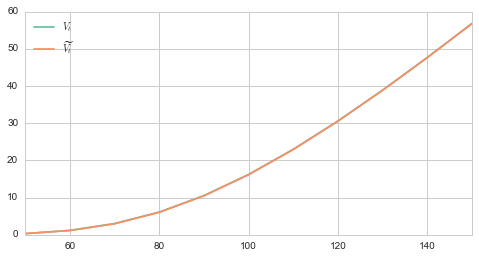

In [403]:
df_plot =  pd.DataFrame(d_rtn, index=l_prices)
df_plot.plot()

### 4.2. Contrato Log

## 5. Conclusão

bla bla bla



## 6. Últimas Considerações

A estrutura ficou lenta. A decisão de usar classes ao invez de um array dificultou implementação e provavelmente tenha prejudicado a velocidade. O exemplo feito do livro não bateu. Porém, as visualizações indicam que a implementação está correta

_Style notebook and change matplotlib defaults_

In [414]:
#loading style sheet
from IPython.core.display import HTML
HTML(open('ipython_style.css').read())

In [400]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set2", 10))